In [ ]:
from PIL import Image
from tqdm.auto import tqdm
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from torchvision import transforms

import json

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("valhalla/emoji-diffusion", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("valhalla/emoji-diffusion", subfolder="unet")

#4. the schedule algorithm used to "renoise" the image
scheduler = LMSDiscreteScheduler.from_pretrained("valhalla/emoji-diffusion", subfolder="scheduler")

# moving to GPU and halving precision for inference speed.
vae = vae.to(torch_device).half()
text_encoder = text_encoder.to(torch_device).half()
unet = unet.to(torch_device).half()

An error occurred while trying to fetch valhalla/emoji-diffusion: valhalla/emoji-diffusion does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch valhalla/emoji-diffusion: valhalla/emoji-diffusion does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [89]:
#define embedding generation function for downstream use - this
def text_embedder(text):
    text_input = tokenizer(text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    return text_embeddings

In [90]:
def latents2img(latents):
    latents = 1 / 0.18215 * latents
    latents = latents.half()
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    # print(images.shape)
    pil_images = [Image.fromarray(image) for image in images]

    pil_images[0]
    return pil_images[0]

In [91]:
#function for image generation
def StableDiffusion(
                    #uncond_input, 
                    #text_input,
                    text_embeddings, 
                    height, 
                    width, 
                    num_inference_steps, 
                    guidance_scale, 
                    seed, 
                    image):
    # text_embeddings=text_embedder(text_input)
    # uncond_embeddings=text_embedder(uncond_input)
    uncond_embeddings=text_embedder('')


    batch_size=1

    generator=torch.manual_seed(seed)

    if not image:
        latents = torch.randn(
            (batch_size, unet.config.in_channels, height // 8, width // 8),
            generator=generator,
            )
    else:
        latents = injection_image2latent(image)

    latents = latents.to(torch_device)

    latents = latents * scheduler.init_noise_sigma

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    scheduler.set_timesteps(num_inference_steps)

    noisy_outputs_list=[]
    clean_outputs_list=[]
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t).half()

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        all_latents = scheduler.step(noise_pred, t, latents)
        clean_latents = all_latents.pred_original_sample
        latents = all_latents.prev_sample
        #save intermediate decoded outputs, for viewing pleasure
        noisy_outputs_list.append(latents2img(latents))
        clean_outputs_list.append(latents2img(clean_latents))

    input_dict={
        # 'uncond_input': uncond_input,
        # 'text_input': text_input,
        'height': height,
        'width': width,
        'num_inference_steps': num_inference_steps,
        'guidance_scale': guidance_scale,
        'seed': seed,
        'image': image
    }
    return (noisy_outputs_list, clean_outputs_list, input_dict)

In [92]:
test = tokenizer('an abstract, colourful, gradient image representing a neutral neutral-watching neutral neutral netflix consumer')

In [93]:
len(test.input_ids)

19

In [94]:
test2 = tokenizer('an abstract, colourful, gradient image representing a happy drama-watching old casual netflix consumer')

In [95]:
len(test2.input_ids)

19

In [96]:
output=StableDiffusion(
    text_embeddings = text_embedder('an abstract, colourful, gradient image representing a sad crime-watching young casual netflix consumer'),
    height=512,
    width=512,
    num_inference_steps=10,
    guidance_scale=7.5,
    seed=42,
    image=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


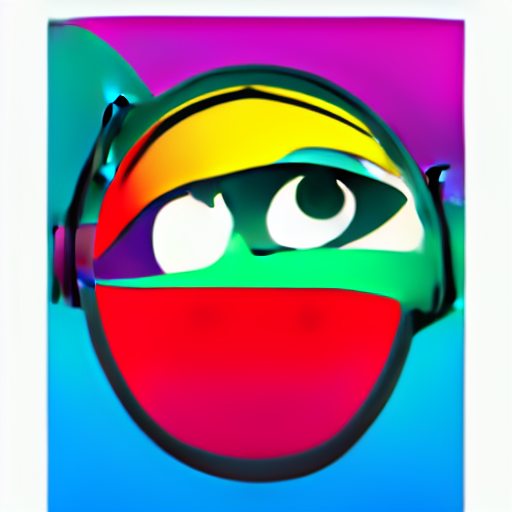

In [97]:
output[1][-1]

In [98]:
test = text_embedder('an abstract, colourful, gradient image representing a sad crime-watching young casual netflix consumer')

In [99]:
test2 = text_embedder('an abstract, colourful, gradient image representing a neutral neutral-watching neutral neutral netflix consumer')

In [100]:
test = tokenizer('an abstract, colourful, gradient image representing a sad crime-watching young casual netflix consumer')

In [101]:
test2 = tokenizer.batch_decode(test.input_ids)

In [102]:
test2[10]

'sad'

In [103]:
10, 11, 14, 15

(10, 11, 14, 15)

In [104]:
test.shape

AttributeError: 

In [ ]:
torch.set_printoptions(profile="default")


In [ ]:
print(test)

In [ ]:
test[0][14]

In [ ]:
neutral = test2

In [ ]:
descriptors = test

In [ ]:
final = test2

In [ ]:
def scaling_func(sad, crime, young, casual):
    final = neutral
    final[0][10] = neutral[0][10]*(1-sad) + descriptors[0][10]*sad
    final[0][11] = neutral[0][11]*(1-crime) + descriptors[0][11]*crime
    final[0][14] = neutral[0][14]*(1-young) + descriptors[0][14]*young
    final[0][15] = neutral[0][15]*(1-casual) + descriptors[0][15]*casual
    return final

In [ ]:
output=StableDiffusion(
    text_embeddings = scaling_func(0,0,0,0),
    height=512,
    width=512,
    num_inference_steps=10,
    guidance_scale=7.5,
    seed=42,
    image=False)

output[1][-1]

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.54it/s]


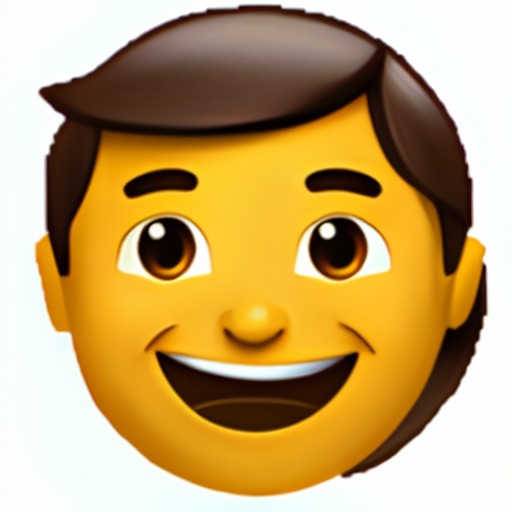

In [116]:
output=StableDiffusion(
    text_embeddings = text_embedder('laugh emoji'),
    height=512,
    width=512,
    num_inference_steps=50,
    guidance_scale=7.5,
    seed=42,
    image=False)

output[1][-1]

In [82]:
descriptors

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.4614, -1.1611,  1.1406,  ..., -0.0694,  0.9712,  0.6162],
         [-0.7427,  0.1273,  0.3923,  ..., -0.1553, -1.2725,  1.1484],
         ...,
         [-0.3298, -0.8613,  0.0828,  ..., -0.5830,  0.2500, -0.2219],
         [-0.3157, -0.8857,  0.0969,  ..., -0.5752,  0.2500, -0.2026],
         [-0.4009, -0.7324,  0.1464,  ..., -0.5493,  0.2286, -0.2112]]],
       device='cuda:0', dtype=torch.float16)

In [110]:
test = (text_embedder('happy emoji') + text_embedder('sad emoji'))/2